In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import datetime

import imageio
from skimage.measure import block_reduce

In [2]:
patch_size = 16
nb_channels = 3

batch_size = 32

In [3]:
base_dir = '/home/niaki/Code/ImageNet/tiny-imagenet-200'

train_data_dir      = base_dir + '/tiny_train16'
validation_data_dir = base_dir + '/tiny_validation16'
test_data_dir       = base_dir + '/tiny_test16'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches_in  -- tensor of stacked patches in their original shape, 16x16
        patches_out -- tensor of the original patches downsampled to 8x8
    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = block_reduce(patch_in, (2, 2, 1), func=np.mean)  # downsample (mean-pool)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
#     patches_in = np.expand_dims(patches_in, -1)  # need this if grayscale
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
#     patches_out = np.expand_dims(patches_out, -1)  # need this if grayscale
        
    print("in", patches_in.shape, "; out", patches_out.shape)
    
    return patches_in, patches_out

In [5]:
x_train, _ = loading_data(train_data_dir)  # y_train
x_validation, _ = loading_data(validation_data_dir)  # y_validation

in (157086, 16, 16, 3) ; out (157086, 8, 8, 3)
in (3932, 16, 16, 3) ; out (3932, 8, 8, 3)


In [6]:
# do I copy or do I just point to the same thing?
#   I think I can just point to the same thing
y_train = x_train
y_validation = x_validation

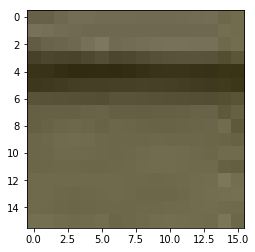

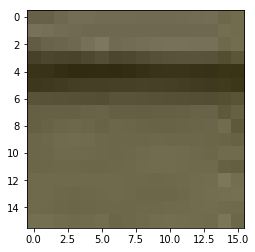

In [7]:
temp_index = np.random.randint(x_train.shape[0]) #  5429
# print(np.array(np.round(x_train[temp_index] * 255), dtype=np.uint8))
plt.imshow(np.array(np.round(x_train[temp_index] * 255), dtype=np.uint8))
plt.show()
plt.imshow(np.array(np.round(y_train[temp_index] * 255), dtype=np.uint8))
plt.show()

In [8]:
input_shape = (patch_size, patch_size, nb_channels)
input_img = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation="elu", padding="same")(input_img)
x = Conv2D(32, (3, 3), activation="elu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="elu", padding="same")(x)
x = MaxPool2D((2, 2), padding="same")(x)
x = MaxPool2D((2, 2), padding="same")(x)
encoded = MaxPool2D((2, 2), padding="same")(x)


x = Conv2D(32, (3, 3), activation="elu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="elu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="elu", padding="same")(x)  # decoded = Conv2D(3, (3, 3), activation="elu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation="elu", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0     

In [15]:
model_version_dwnsmpld_output = 'patch_desc_ae_20201026_14251116_alex_3conv3mp_2020_augm_elu_lastelu_dwnsmpl'
autoencoder_dwnsmpld_output = load_model(base_dir + '/' + model_version_dwnsmpld_output + '.h5')

for i in range(11):
    print(autoencoder_dwnsmpld_output.get_layer(index=i))
    autoencoder.get_layer(index=i).set_weights(autoencoder_dwnsmpld_output.get_layer(index=i).get_weights())

In [16]:
image_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=False, fill_mode="nearest")

In [17]:
import wandb
from wandb.keras import WandbCallback
# os.environ['WANDB_MODE'] = 'dryrun'

In [32]:
run = wandb.init(
  project="patch-desc-ae",
  config={
    "augmentation": True,
    "elus": False,
    "last_layer_activation": "elu",
    "downsampling_output": False,
    "optimizer": "adadelta", 
    "loss": "binary_crossentropy",
    "epochs": 1000 }
)

wandb: wandb version 0.10.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [33]:
%%wandb

model_version = 'patch_desc_ae_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '16_alex_3conv3mp_2020_augm_elu_lastelu_NOTdwnsmpl_500moreepochs'

os.system('mkdir ' + base_dir + '/weights_' + model_version)
print(base_dir + '/weights_' + model_version)

# checkpointer = ModelCheckpoint(base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history_callback = autoencoder.fit(image_datagen.flow(x_train, y_train, batch_size),
                epochs=500,#wandb.config.epochs,
                validation_data=image_datagen.flow(x_validation, y_validation, batch_size),
                callbacks=[WandbCallback(data_type="image", predictions=1)]
                )
autoencoder.save(base_dir + '/' + model_version + '.h5')

# autoencoder = load_model(base_dir + '/' + model_version + '.h5')

/home/niaki/Code/ImageNet/tiny-imagenet-200/weights_patch_desc_ae_20201028_10450816_alex_3conv3mp_2020_augm_elu_lastelu_NOTdwnsmpl_500moreepochs
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4909 steps, validate for 123 steps
Epoch 1/500
4909/4909 [==============================] - 63s 13ms/step - loss: 0.5373 - val_loss: 0.5330
Epoch 2/500
4909/4909 [==============================] - 62s 13ms/step - loss: 0.5374 - val_loss: 0.5333
Epoch 3/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5374 - val_loss: 0.5330
Epoch 4/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5373 - val_loss: 0.5329
Epoch 5/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5373 - val_loss: 0.5330
Epoch 6/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5374 - val_loss: 0.5328
Epoch 7/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5373 - val_loss: 0.5334
Epoch 8/500
4909/4909 [==

4909/4909 [==============================] - 61s 12ms/step - loss: 0.5372 - val_loss: 0.5330
Epoch 76/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5372 - val_loss: 0.5327
Epoch 77/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5372 - val_loss: 0.5329
Epoch 78/500
4909/4909 [==============================] - 61s 13ms/step - loss: 0.5372 - val_loss: 0.5330
Epoch 79/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5371 - val_loss: 0.5326
Epoch 80/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5372 - val_loss: 0.5329
Epoch 81/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5371 - val_loss: 0.5331
Epoch 82/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5372 - val_loss: 0.5327
Epoch 83/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5371 - val_loss: 0.5326
Epoch 84/500
4909/4909 [==============================] - 6

Epoch 152/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5370 - val_loss: 0.5326
Epoch 153/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5370 - val_loss: 0.5331
Epoch 154/500
4909/4909 [==============================] - 61s 13ms/step - loss: 0.5370 - val_loss: 0.5328
Epoch 155/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5370 - val_loss: 0.5331
Epoch 156/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5370 - val_loss: 0.5328
Epoch 157/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5370 - val_loss: 0.5326
Epoch 158/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5370 - val_loss: 0.5325
Epoch 159/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5370 - val_loss: 0.5328
Epoch 160/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5370 - val_loss: 0.5329
Epoch 161/500
4909/4909 [============

4909/4909 [==============================] - 61s 12ms/step - loss: 0.5368 - val_loss: 0.5327
Epoch 305/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5368 - val_loss: 0.5324
Epoch 306/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5369 - val_loss: 0.5324
Epoch 307/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5367 - val_loss: 0.5326
Epoch 308/500
4909/4909 [==============================] - 61s 13ms/step - loss: 0.5368 - val_loss: 0.5324
Epoch 309/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5368 - val_loss: 0.5327
Epoch 310/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5368 - val_loss: 0.5327
Epoch 311/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5367 - val_loss: 0.5322
Epoch 312/500
4909/4909 [==============================] - 60s 12ms/step - loss: 0.5368 - val_loss: 0.5325
Epoch 313/500
4909/4909 [==========================

4909/4909 [==============================] - 62s 13ms/step - loss: 0.5366 - val_loss: 0.5323
Epoch 457/500
4909/4909 [==============================] - 62s 13ms/step - loss: 0.5366 - val_loss: 0.5321
Epoch 458/500
4909/4909 [==============================] - 61s 12ms/step - loss: 0.5367 - val_loss: 0.5323
Epoch 459/500
4909/4909 [==============================] - 62s 13ms/step - loss: 0.5366 - val_loss: 0.5326
Epoch 460/500
4909/4909 [==============================] - 62s 13ms/step - loss: 0.5367 - val_loss: 0.5322
Epoch 461/500
4909/4909 [==============================] - 62s 13ms/step - loss: 0.5366 - val_loss: 0.5326
Epoch 462/500
4909/4909 [==============================] - 62s 13ms/step - loss: 0.5366 - val_loss: 0.5321
Epoch 463/500
4909/4909 [==============================] - 62s 13ms/step - loss: 0.5366 - val_loss: 0.5326
Epoch 464/500
4909/4909 [==============================] - 62s 13ms/step - loss: 0.5366 - val_loss: 0.5320
Epoch 465/500
4909/4909 [==========================

In [34]:
history_callback.history

{'loss': [0.5373435755432614,
  0.5373800206262248,
  0.5373584119542304,
  0.5373311023749161,
  0.5373463065569325,
  0.5374247160637902,
  0.5373397593301347,
  0.5373659492769903,
  0.5373262869619335,
  0.5373255755381565,
  0.5373322435618191,
  0.5373605004006443,
  0.5373842533065354,
  0.5373109773932319,
  0.5373075901103612,
  0.5372797005185772,
  0.5373263320495997,
  0.5372873707730589,
  0.5373090409681446,
  0.5372899403052159,
  0.5372951971009025,
  0.5373098743498714,
  0.5372720264272026,
  0.5372631904698477,
  0.5372953976590009,
  0.5372433258876771,
  0.5372648283841313,
  0.5372255572386425,
  0.5372599915089081,
  0.5372577717726076,
  0.537279012511534,
  0.5373297580159555,
  0.5372395601172472,
  0.5372635390556714,
  0.537280502683431,
  0.5372785964291019,
  0.5372627720732137,
  0.5372129588996326,
  0.53725750047521,
  0.5373044582715233,
  0.5372284339775995,
  0.5372233747526837,
  0.5372349500209148,
  0.5372533811353971,
  0.5371964296630233,
  0.53

predictions: 


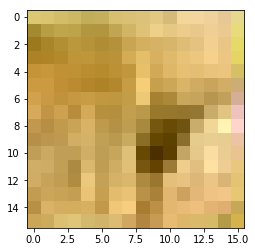

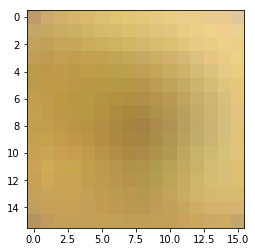

next


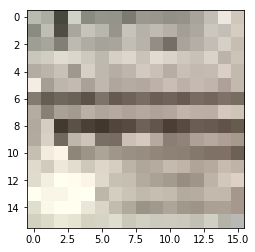

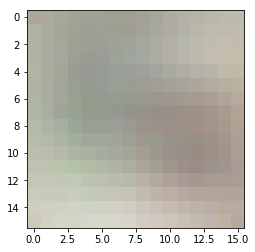

next


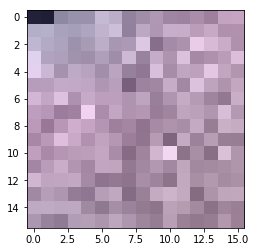

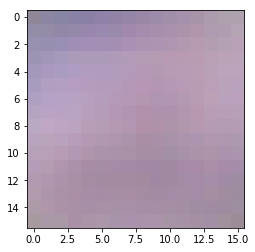

In [36]:
images_directory = base_dir + '/tiny_test16/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
#         img = load_img(images_directory + '/' + file, False, target_size=(patch_size, patch_size))
#         x = img_to_array(img)
#         x = np.expand_dims(x, axis=0)
#         images.append(x)
        
#         img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = autoencoder.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1, interpolation='nearest')
    plt.show()
    
    pred_1 = predictions[i].numpy()#.reshape(input_shape)
    plt.imshow(pred_1, interpolation='nearest')
    plt.show()
    
    if i == 2:
        break
    print("next")


In [37]:
encoder = Model(input_img, encoded)
for i in range(1, len(encoder.layers)):
    print(encoder.get_layer(index=i))
    encoder.get_layer(index=i).set_weights(autoencoder.get_layer(index=i).get_weights())
encoder.summary()

# encoder.save(base_dir + '/encoder' + model_version + '.h5')
encoder.save(base_dir + '/' + model_version + '__encoder.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0   

In [38]:
predictions = encoder.predict_on_batch(np.array(images))

In [39]:
predictions[3]

<tf.Tensor: shape=(2, 2, 32), dtype=float32, numpy=
array([[[ 0.05565583, -0.24996227, -0.0791648 ,  0.16771457,
          0.03777337,  0.10455577, -0.01680624,  0.11207959,
          0.11137222,  0.06271623,  0.2315485 , -0.0628413 ,
          0.14516146,  0.01177703, -0.01242101,  0.02389297,
          0.1414031 ,  0.11302765,  0.07147142, -0.03023916,
          0.01645315,  0.12330112, -0.01693118, -0.13514245,
          0.20743653,  0.1307104 , -0.08437359,  0.0431138 ,
         -0.2035501 , -0.04094815,  0.08355999,  0.03386394],
        [ 0.11568862, -0.15564966,  0.03081474,  0.0972597 ,
         -0.00263065,  0.09159648,  0.05533858,  0.04699807,
          0.0105389 ,  0.07237399,  0.24377885, -0.02887267,
          0.07086342, -0.10889471,  0.09135725,  0.12757508,
          0.10404458,  0.12367651,  0.08487045,  0.07352839,
          0.06241041,  0.14231765,  0.06690668,  0.03413185,
          0.16080754,  0.16138   , -0.15063149, -0.12105423,
         -0.0290063 , -0.1004972

In [40]:
np.min(predictions.numpy())

-0.3659482

In [41]:
np.max(predictions.numpy())

0.4363702

In [42]:
predictions.shape

TensorShape([100, 2, 2, 32])

In [43]:
run.finish()

epoch,499
loss,0.53661
val_loss,0.53239
_step,499
_runtime,30774
_timestamp,1603908962
best_val_loss,0.53186
best_epoch,498


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇█▇▆▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁
val_loss,██▇▆█▇█▆█▇▇▅▇▆▇▄▆▅▄▆▆▆▃▆▅▃▄▇▅▃▄▃▃▁▂▄▃▃▅▆
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


(array([  70.,  227.,  870., 1521., 3280., 3529., 2175.,  734.,  289.,
         105.]),
 array([-0.3659482 , -0.28571635, -0.20548452, -0.12525268, -0.04502084,
         0.035211  ,  0.11544283,  0.19567467,  0.2759065 ,  0.35613835,
         0.4363702 ], dtype=float32),
 <a list of 10 Patch objects>)

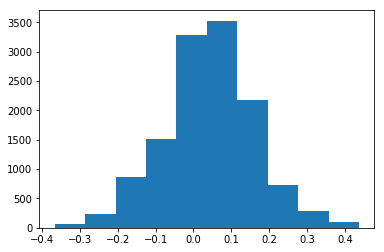

In [44]:
plt.hist(predictions.numpy().flatten())

In [48]:
np.argmin(history_callback.history["val_loss"])

498